In [41]:
# Aim of the exercise is to measure effectiveness of each marketing channel and create a budget allocator for the Markerting Team 
# Hence we would be going for explanatory model and not a predictive model 

In [42]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [43]:
import seaborn as sns 
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.outliers_influence import variance_inflation_factor

from matplotlib.pyplot import figure

from math import ceil
import datetime

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import max_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

from datetime import date,timedelta


import warnings; warnings.simplefilter('ignore')


In [44]:
def week_of_month(dt):
    """ Returns the week of the month for the specified date.
    """

    first_day = dt.replace(day=1)

    dom = dt.day
    adjusted_dom = dom + first_day.weekday()

    return int(ceil(adjusted_dom/7.0))

# Decomposition
def decompose(df_col,period,model):
    decomposition = sm.tsa.seasonal_decompose(df_col,period =12,model=model) 
    figure2 = decomposition.plot()
    figure(figsize=(16, 12), dpi=80)
    plt.show()

# Adfuller Test
def adftest(df_col):
    result = adfuller(df_col)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print(f'Critical Values:')
    for key,val in result[4].items():
        print(f'{key} {val}')

# Plot ACF and PACF
def plot_apacf(df_col,lags):
    plot_acf(df_col, lags=lags)
    plt.show()
    plot_pacf(df_col,lags=lags)
    plt.show()
    
# Check VIF
def checkVIF(df,cols):
    vif_data = pd.DataFrame()
    X = df[cols]
    vif_data["feature"] = X.columns
  
    # calculating VIF for each feature
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
    return vif_data

## Doing Log Transformations
def logTransform(df,cols):
    temp = df.copy()
    arr = []
    for j in cols:
        temp[f'ln_{j}'] = np.log(temp[j])
        arr.append(f'ln_{j}')
    return(temp,arr)


In [45]:
# Fit a simple Linear regression 
# Input : Dataframe, Dependent Var, Independent Var, True/False for only positive Coeff, True/False for Plots
def LRfit(df,dv,iv,ng,plot,printstats):
    tt = df[df[dv].isna()==False]
    reg_nnls = LinearRegression(positive=ng)

    X = tt[iv]
    y = tt[dv]

    reg_nnls2 = reg_nnls.fit(X,y)

    y_pred = reg_nnls2.predict(X)
    
    vif = checkVIF(X,iv)
    
    

    run_year = tt['Date'].min()
    r2 = r2_score(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y,y_pred))
    nmrse1 = rmse/y.std()
    nmrse2 = rmse/(y.max() - y.min())
    mae = mean_absolute_error(y,y_pred)
    mape = mean_absolute_percentage_error(y,y_pred)
    

    coeff_arr = []

    for q in reg_nnls2.coef_: 
        coeff_arr = np.insert(coeff_arr,len(coeff_arr),round(q,4))
    inter = reg_nnls2.intercept_
    r2 = r2_score(y, y_pred)
    
    if printstats ==True:
        print(vif)
        print(run_year)
        print(reg_nnls2.intercept_)
        print(f'Coeff : {coeff_arr}')
        print(f"R2 : {(r2)}")
        print(f"RMSE : {rmse}")
        print(f"NMRSE1 : {nmrse1}")
        print(f"NMRSE2 : {nmrse2}")
        print(f"MAE : {(mae)}")
        print(f"MAPE : {(mape)}")

    if plot == True:
        sns.lineplot(data=tt,x=range(len(X)),y=dv,label='1')
        sns.lineplot(x=range(len(y_pred)),y=y_pred,label='2')

    return(y_pred,run_year,dv,iv,r2,rmse,nmrse1,nmrse2,mae,mape,inter,coeff_arr,vif)


def convert_lr_fit_to_df(df, dv, iv):
    return pd.DataFrame([LRfit(df,dv,iv)], columns=['model_run_TF','DV','IV','R2','RMSE','NMRSE1','NMRSE2','MAE','MAPE','Intercept','Coeff','VIF'])


In [46]:
# Fit a simple Ridge regression 
def RidgeFit(df,dv,iv,ng,st,norm,alph,plot):
    tt = df[df[dv].isna()==False]
    reg = linear_model.Ridge(alpha=alph,positive=ng,normalize=norm)

    X = tt[iv]
    y = tt[dv]

    reg2 = reg.fit(X,y)

    y_pred = reg2.predict(X)
    coeff = reg2.coef_
    
    inter= reg2.intercept_


    coeff_arr = []

    for q in coeff: 
        coeff_arr = np.insert(coeff_arr,len(coeff_arr),round(q,4))

    run_year = tt['Date'].min()
    r2 = r2_score(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y,y_pred))
    nmrse1 = rmse/y.std()
    nmrse2 = rmse/(y.max() - y.min())
    mae = mean_absolute_error(y,y_pred)
    mape = mean_absolute_percentage_error(y,y_pred)

    vif = checkVIF(X,iv)
    

    if plot == True:
        sns.lineplot(data=tt,x=range(len(X)),y=dv,label='1')
        sns.lineplot(x=range(len(y_pred)),y=y_pred,label='2')
        print(vif)
        print(f'Intercept : {inter}')
        print(f'Coeff : {coeff_arr}')
        print(f'R2 : {r2}')
        print(f'RMSE : {rmse}')
        print(f'MAE : {mae}')
        print(f'MAPE : {mape}')

    return(st,y_pred,run_year,dv,iv,r2,rmse,nmrse1,nmrse2,mae,mape,inter,coeff_arr,vif)

def convert_ridge_fit_to_df(df, dv, iv,ng,st,norm,alph):
    return pd.DataFrame([RidgeFit(df,dv,iv,ng,st,norm,alph,False)], columns=['base iv','y_pred','model_run_TF','DV','IV','R2','RMSE','NMRSE1','NMRSE2','MAE','MAPE','intercept','Coeff','VIF'])


In [47]:
## Subset according to days
def dfTFdays(df,days):
    return(df[df['Date']>=[date.today()- timedelta(days=days)]*len(df)])

def spliceTF(df,days,enddt):
     return(df[(df['Date']<=enddt) & (df['Date']>=[pd.to_datetime(enddt)- timedelta(days=days)]*len(df))])

In [48]:
# read input file
data = pd.read_csv('Burger_Sales.csv')
print(f'Lenght of Data Frame : {len(data)}')
print(f'Minimum Date : {data[data.columns[0]].min()}')
print(f'Minimum Date : {data[data.columns[0]].max()}')
print(f'Columns : {data.columns}')

Lenght of Data Frame : 850
Minimum Date : 2020-01-01
Minimum Date : 2022-05-31
Columns : Index(['Date', 'burger_sales', 'Instagram_Cost', 'Bing_Cost', 'Facebook_Cost',
       'Google_Cost', 'Pinterest_Cost', 'Tiktok Cost'],
      dtype='object')


In [49]:
data

,Date,burger_sales,Instagram_Cost,Bing_Cost,Facebook_Cost,Google_Cost,Pinterest_Cost,Tiktok Cost
0,2020-01-01,950,0.0,0.0,1041.1,4447.40000,0.0,0.0
1,2020-01-02,1340,582.5,0.0,2597.0,6561.10000,0.0,0.0
2,2020-01-03,1370,551.5,0.0,2580.0,6500.30000,0.0,0.0
3,2020-01-04,1160,0.0,0.0,2245.5,6499.60000,0.0,0.0
4,2020-01-05,1070,540.0,0.0,1751.1,6499.10000,0.0,0.0
...,...,...,...,...,...,...,...,...
845,2022-05-09,10630,27689.7,21901.7,47154.0,112787.84487,25793.2,20479.5
846,2022-05-28,10930,0.0,0.0,38461.0,64788.29081,21939.2,0.0
847,2022-05-29,10510,0.0,0.0,45635.0,89638.52679,21673.6,0.0
848,2022-05-30,13160,7424.3,0.0,91366.7,133683.23351,20171.6,0.0


In [50]:
corr = data_sel[['burger_sales', 'Instagram_Cost', 'Bing_Cost', 'Facebook_Cost',
       'Google_Cost', 'Pinterest_Cost', 'Tiktok Cost']].corr()

sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

# It seems our dataset has a lot of correlation in between the spends 
# Note: Marketing spends are generally increased/decreased across channels together


NameError: name 'data_sel' is not defined

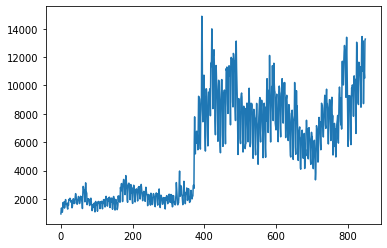

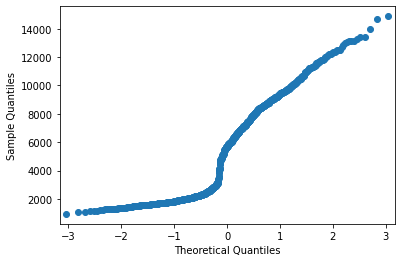

In [ ]:
# overall Burger Sales Time Series
plt.plot(data['burger_sales'])
plt.show()

# Q-Q Plot : To check for normality
sm.qqplot(data['burger_sales'])
plt.show()

<AxesSubplot:xlabel='burger_sales', ylabel='Density'>

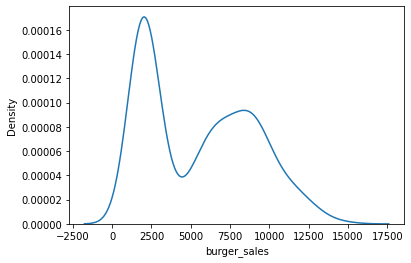

In [ ]:
sns.kdeplot(data['burger_sales'])
# Two different distribution of Sales ; This might be due to new marketing channels coming into play  

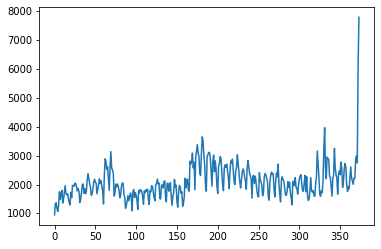

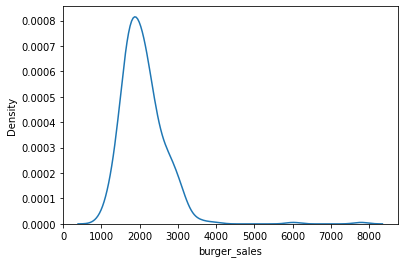

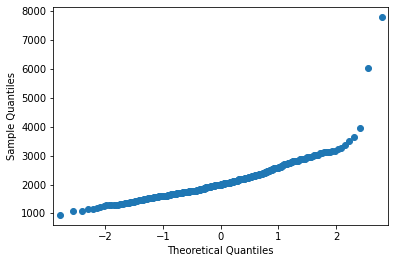

In [ ]:
# Considering the time before 2021
date_cond = data['Date'] < '2021-01-09'
plt.plot(data[date_cond][:]['burger_sales'])
plt.show()

sns.kdeplot(data[date_cond]['burger_sales'])
plt.show()

# Q-Q Plot : To check for normality
sm.qqplot(data[date_cond]['burger_sales'])
plt.show()

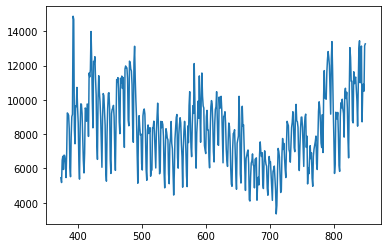

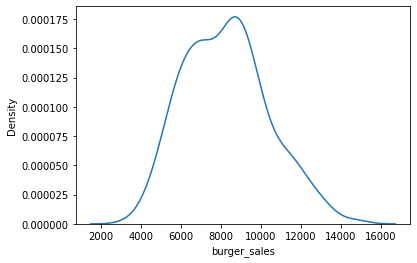

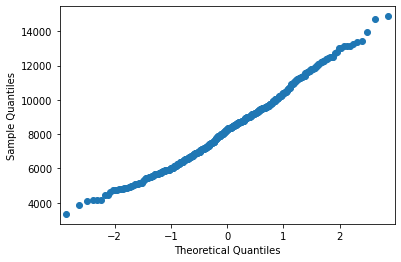

In [ ]:
# Time period after 2021 
# Let us use this more recent data to model the relationship between sales and marketing spends

date_cond = data['Date'] > '2021-01-08'
plt.plot(data[date_cond][:]['burger_sales'])
plt.show()

sns.kdeplot(data[date_cond]['burger_sales'])
plt.show()

# Q-Q Plot : To check for normality
sm.qqplot(data[date_cond]['burger_sales'])
plt.show()

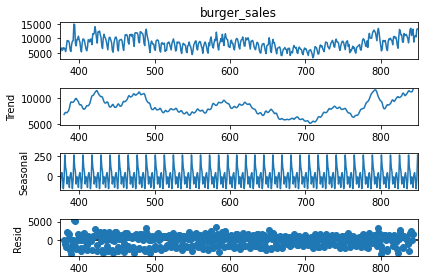

<Figure size 1280x960 with 0 Axes>

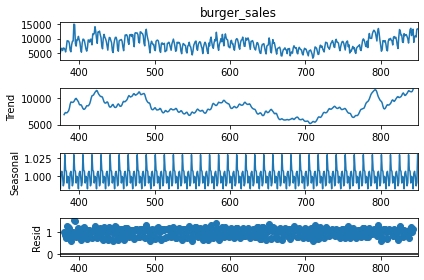

<Figure size 1280x960 with 0 Axes>

In [ ]:
data_sel = data[date_cond]
decompose(data_sel['burger_sales'],12,'additive')
decompose(data_sel['burger_sales'],12,'multiplicative')

# Seems like a multiplicative model would be better as the residuals are mode stable 

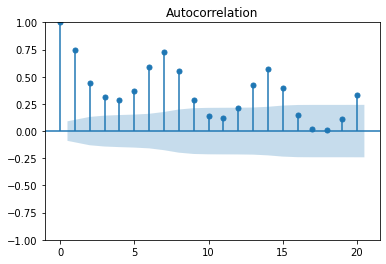

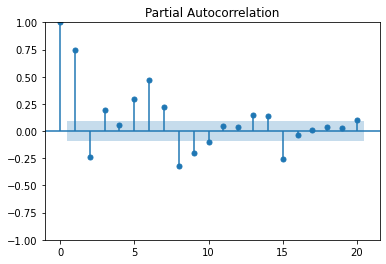

In [ ]:
plot_apacf(data_sel['burger_sales'],20)

In [ ]:
# Lets check for Multicollinearity 

checkVIF(data_sel,['burger_sales', 'Instagram_Cost', 'Bing_Cost', 'Facebook_Cost','Google_Cost', 'Pinterest_Cost', 'Tiktok Cost'])

,feature,VIF
0,burger_sales,6.310826
1,Instagram_Cost,4.796140
2,Bing_Cost,3.703062
3,Facebook_Cost,4.767385
4,Google_Cost,10.079515
5,Pinterest_Cost,1.421077
6,Tiktok Cost,3.367606


In [ ]:
# Replacing 0 by 0.01 in any spends , so that a log transformation can be taken
for q in data_sel.columns[1:]:
    print(q)
    data_sel[q] = np.where(data_sel[q]==0,0.01,data_sel[q])
    data_sel[f'ln_{q}'] = np.log(data_sel[q])
    

# We will create some seasonality features eg : year, month, day, dayofweek, weekofmonth

data_sel['Date'] = pd.to_datetime(data_sel['Date'])
data_sel['year'] = data_sel['Date'].dt.year
data_sel['month'] = data_sel['Date'].dt.month
data_sel['day'] = data_sel['Date'].dt.day
data_sel['dayofWeek'] = data_sel['Date'].dt.dayofweek
data_sel['dayofWeek']  = data_sel['dayofWeek']  + 1
data_sel['weekOfMonth'] = data_sel['Date'].apply(lambda x: week_of_month(x))
data_sel['weekofYear'] = data_sel.apply(lambda x: datetime.date(x.year, x.month, x.day).isocalendar()[1], axis=1)


data_sel.head()

burger_sales
Instagram_Cost
Bing_Cost
Facebook_Cost
Google_Cost
Pinterest_Cost
Tiktok Cost
ln_burger_sales
ln_Instagram_Cost
ln_Bing_Cost
ln_Facebook_Cost
ln_Google_Cost
ln_Pinterest_Cost
ln_Tiktok Cost
year
month
day
dayofWeek
weekOfMonth
weekofYear


,Date,burger_sales,Instagram_Cost,Bing_Cost,Facebook_Cost,Google_Cost,Pinterest_Cost,Tiktok Cost,ln_burger_sales,ln_Instagram_Cost,...,ln_ln_Facebook_Cost,ln_ln_Google_Cost,ln_ln_Pinterest_Cost,ln_ln_Tiktok Cost,ln_year,ln_month,ln_day,ln_dayofWeek,ln_weekOfMonth,ln_weekofYear
374,2021-01-09,5460.0,740.6,3446.6,884.6,50088.13748,0.01,0.01,8.605204,6.607461,...,1.914734,2.381539,NaN,NaN,7.611348,0.0,2.197225,1.791759,0.693147,0.000000
375,2021-01-10,5180.0,738.1,3870.7,897.5,46129.49268,0.01,0.01,8.552560,6.604079,...,1.916866,2.373901,NaN,NaN,7.611348,0.0,2.302585,1.945910,0.693147,0.000000
376,2021-01-11,6490.0,1022.1,10999.6,907.1,53740.93674,0.01,0.01,8.778018,6.929615,...,1.918429,2.388022,NaN,NaN,7.611348,0.0,2.397895,0.000000,1.098612,0.693147
377,2021-01-12,6710.0,1071.6,11542.2,930.4,51532.02565,0.01,0.01,8.811354,6.976908,...,1.922146,2.384161,NaN,NaN,7.611348,0.0,2.484907,0.693147,1.098612,0.693147
378,2021-01-13,5940.0,1065.7,8443.9,964.4,51121.08217,0.01,0.01,8.689464,6.971387,...,1.927383,2.383423,NaN,NaN,7.611348,0.0,2.564949,1.098612,1.098612,0.693147


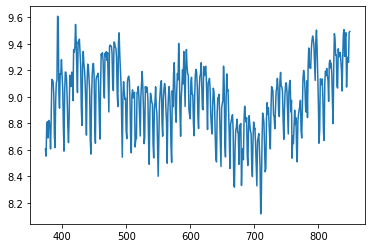

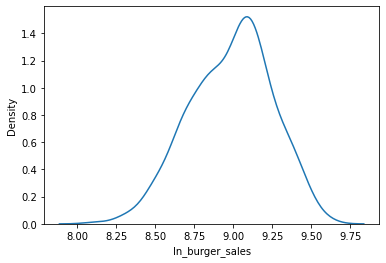

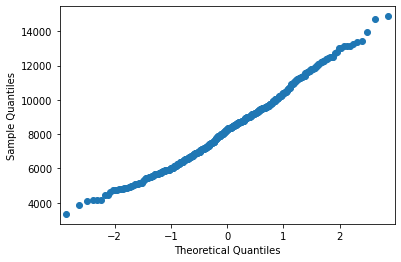

In [ ]:
plt.plot(data_sel[:]['ln_burger_sales'])
plt.show()

sns.kdeplot(data_sel['ln_burger_sales'])
plt.show()

# Q-Q Plot : To check for normality
sm.qqplot(data_sel['burger_sales'])
plt.show()

In [ ]:
# Lets check for Multicollinearity 

checkVIF(data_sel,['burger_sales', 'Instagram_Cost', 'Bing_Cost', 'Facebook_Cost','Google_Cost', 'Pinterest_Cost', 'Tiktok Cost'])

,feature,VIF
0,burger_sales,6.310824
1,Instagram_Cost,4.796142
2,Bing_Cost,3.703063
3,Facebook_Cost,4.767386
4,Google_Cost,10.079514
5,Pinterest_Cost,1.421079
6,Tiktok Cost,3.367609


In [ ]:
checkVIF(data_sel,['ln_burger_sales', 'ln_Instagram_Cost', 'ln_Bing_Cost', 'ln_Facebook_Cost','ln_Google_Cost', 'ln_Pinterest_Cost', 'ln_Tiktok Cost'])

,feature,VIF
0,ln_burger_sales,937.199538
1,ln_Instagram_Cost,15.297736
2,ln_Bing_Cost,14.319830
3,ln_Facebook_Cost,228.682249
4,ln_Google_Cost,1669.569885
5,ln_Pinterest_Cost,11.167139
6,ln_Tiktok Cost,1.556181


In [ ]:
checkVIF(data_sel,['ln_burger_sales', 'Instagram_Cost', 'Bing_Cost', 'Facebook_Cost','Google_Cost', 'Pinterest_Cost', 'Tiktok Cost'])

,feature,VIF
0,ln_burger_sales,6.060476
1,Instagram_Cost,4.742815
2,Bing_Cost,3.851779
3,Facebook_Cost,4.804355
4,Google_Cost,9.917845
5,Pinterest_Cost,1.410855
6,Tiktok Cost,3.616058


In [ ]:
checkVIF(data_sel,['burger_sales','month','dayofWeek','weekOfMonth'])

,feature,VIF
0,burger_sales,6.577855
1,month,2.970469
2,dayofWeek,3.449627
3,weekOfMonth,5.676816


In [ ]:
# We will go with 2 models. 
# First is a base model without spends 
# Second Model will include the base sales and the Marketing Spends

In [ ]:
ctrl_arr = ['month','dayofWeek','weekOfMonth']
iv_arr = ['Instagram_Cost', 'Bing_Cost', 'Facebook_Cost','Google_Cost', 'Pinterest_Cost', 'Tiktok Cost']
iv_ln_arr = ['ln_Instagram_Cost', 'ln_Bing_Cost', 'ln_Facebook_Cost','ln_Google_Cost', 'ln_Pinterest_Cost', 'ln_Tiktok Cost']


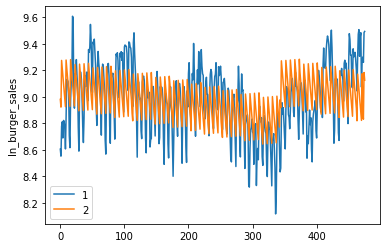

In [ ]:
y_pred,run_year,dv,iv,r2,rmse,nmrse1,nmrse2,mae,mape,inter,coeff_arr,vif = LRfit(data_sel,'ln_burger_sales',ctrl_arr,False,True,False)
data_sel['base_ln'] = y_pred
data_sel['base_y'] = np.exp(y_pred)

base_model_intercept = inter
base_model_coeffs = coeff_arr

             feature          VIF
0            base_ln   860.347219
1  ln_Instagram_Cost    15.136252
2       ln_Bing_Cost    14.404720
3   ln_Facebook_Cost   229.637805
4     ln_Google_Cost  1582.904872
5  ln_Pinterest_Cost    10.180801
6     ln_Tiktok Cost     1.473645
Intercept : 0.7781437646890481
Coeff : [0.7761 0.0232 0.     0.     0.1016 0.0281 0.    ]
R2 : 0.42083399580757697
RMSE : 0.1997955312959078
MAE : 0.163204274706326
MAPE : 0.018162245831038582


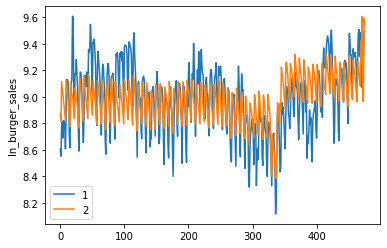

In [ ]:
from sklearn import linear_model
st,y_pred,run_year,dv,iv,r2,rmse,nmrse1,nmrse2,mae,mape,inter,coeff_arr,vif = RidgeFit(data_sel,'ln_burger_sales',np.append(['base_ln'],iv_ln_arr),True,'test',False,1,True)

# We cannot have 0 as coefficient for any of the channels as it means there is 0 contributio from that channel 
# Lets try for different Time periods 

In [ ]:
# we will iterate every 15 days and fit a sales, ln_sales with two different independent variables 
# our objective is to find a time period for each we get a positive coefficient for each channel 
# each row at the end is a model fitted with different metrics

ChampChallenger = pd.DataFrame(columns=['base iv','model_run_TF','DV','IV','R2','RMSE','NMRSE1','NMRSE2','MAE','MAPE','intercept','Coeff','VIF'])
testcp = data_sel.copy()

## Iterating over 1 to 3 years, with 1 month increment
for p in range(180,1080,15):
    
    df = spliceTF(testcp,p,'2022-05-31')
    df,arr1 = logTransform(df,['burger_sales'])
    df,arr1  = logTransform(df,iv_arr)

    y_pred,run_year,dv,iv,r2,rmse,nmrse1,nmrse2,mae,mape,inter,coeff_arr,vif = LRfit(data_sel,'ln_burger_sales',ctrl_arr,False,False,False)
    data_sel['base_ln'] = y_pred
    data_sel['base_y'] = np.exp(y_pred)

    iv_arr = ['base_y','Instagram_Cost', 'Bing_Cost', 'Facebook_Cost','Google_Cost', 'Pinterest_Cost', 'Tiktok Cost']
    iv_ln_arr = ['base_ln','ln_Instagram_Cost', 'ln_Bing_Cost', 'ln_Facebook_Cost','ln_Google_Cost', 'ln_Pinterest_Cost', 'ln_Tiktok Cost']

   
    dvt = ['burger_sales','ln_burger_sales']

    for ivt in [iv_ln_arr]:
        for dvtp in dvt:
            if (convert_ridge_fit_to_df(df=df, dv=dvtp, iv=ivt,ng=True,st=f' na',norm=False,alph=0.9).iloc[0]['Coeff'].min()<=0):
                continue
            else:
                ChampChallenger = ChampChallenger.append(convert_ridge_fit_to_df(df=df, dv=dvtp, iv=ivt,ng=True,st=f'alpha:{p}',norm=False,alph=0.9))

ChampChallenger = ChampChallenger.sort_values(by='MAPE',ascending=True)


ChampChallenger

,base iv,model_run_TF,DV,IV,R2,RMSE,NMRSE1,NMRSE2,MAE,MAPE,intercept,Coeff,VIF,y_pred
0,alpha:195,2021-11-17,ln_burger_sales,"[base_ln, ln_Instagram_Cost, ln_Bing_Cost, ln_...",0.835002,0.118115,0.405056,0.084973,0.090641,0.010149,3.359185,"[0.0703, 0.0042, 0.0009, 0.1625, 0.2823, 0.029...",feature VIF 0 ...,"[8.63482088011644, 8.661414132861463, 8.652224..."
0,alpha:180,2021-12-02,ln_burger_sales,"[base_ln, ln_Instagram_Cost, ln_Bing_Cost, ln_...",0.834574,0.117454,0.405477,0.084498,0.091511,0.010224,3.152914,"[0.0695, 0.0021, 0.0008, 0.1676, 0.2955, 0.030...",feature VIF 0 ...,"[8.672379755862524, 8.646901047611097, 8.47682..."
0,alpha:210,2021-11-02,burger_sales,"[base_ln, ln_Instagram_Cost, ln_Bing_Cost, ln_...",0.800444,1031.767819,0.445558,0.102155,733.570083,0.093969,-31554.028275,"[365.9176, 22.1841, 10.4703, 1481.9855, 1841.2...",feature VIF 0 ...,"[6948.307978766752, 6796.842100924849, 6694.80..."


       feature       VIF
0        month  2.318360
1    dayofWeek  2.814324
2  weekOfMonth  3.097015
2021-11-17 00:00:00
9.29974879006081
Coeff : [-0.0325 -0.0513  0.0087]
R2 : 0.3359360833569892
RMSE : 0.23695726875721154
NMRSE1 : 0.8126088976144028
NMRSE2 : 0.17047055445587211
MAE : 0.19174133554948863
MAPE : 0.02135568105420433
             feature          VIF
0            base_ln  1824.273492
1  ln_Instagram_Cost     7.501901
2       ln_Bing_Cost     6.578905
3   ln_Facebook_Cost   305.558332
4     ln_Google_Cost  2485.144279
5  ln_Pinterest_Cost     5.698448
6     ln_Tiktok Cost     2.163425
Intercept : 3.483744451654868
Coeff : [0.0588 0.0043 0.0013 0.1654 0.2779 0.0288 0.0019]
R2 : 0.8334376606745947
RMSE : 0.11867343139621565
MAE : 0.09109118208512078
MAPE : 0.010200531761422334


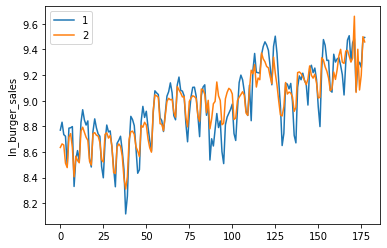

In [ ]:
# we will take the top row as model 
from sklearn import linear_model

testcp = data_sel.copy()
testcp = spliceTF(testcp,195,'2022-05-31')

y_pred,run_year,dv,iv,r2,rmse,nmrse1,nmrse2,mae,mape,inter,coeff_arr,vif = LRfit(testcp,'ln_burger_sales',ctrl_arr,False,False,True)
testcp['base_ln'] = y_pred
testcp['base_y'] = np.exp(y_pred)
st,y_pred,run_year,dv,iv,r2,rmse,nmrse1,nmrse2,mae,mape,inter,coeff_arr,vif = RidgeFit(testcp,'ln_burger_sales',iv_ln_arr,True,'test',False,1,True)

In [ ]:
"""
Our final model : 

1. Control Model : 
Intercept : 9.29974879006081
Coeff : [-0.0325 -0.0513  0.0087]

2. MMM Model : 
Intercept : 3.379554614274598
Coeff : [0.0692 0.0043 0.0013 0.1646 0.2793 0.0289 0.002 ]

"""

'\nOur final model : \n\n1. Control Model : \nIntercept : 9.29974879006081\nCoeff : [-0.0325 -0.0513  0.0087]\n\n2. MMM Model : \nIntercept : 3.379554614274598\nCoeff : [0.0692 0.0043 0.0013 0.1646 0.2793 0.0289 0.002 ]\n\n'

In [ ]:
# storing final model coeffs and intercepts
base_intecept = 9.29974879006081
base_coeffs = [-0.0325, -0.0513,  0.0087]

mmm_intercept = 3.379554614274598
mmm_coeff = [0.0692, 0.0043, 0.0013, 0.1646, 0.2793, 0.0289, 0.002 ]


In [ ]:
# calculating channel contributions and ROAS
df = testcp.copy()
df.columns

coeffs = mmm_coeff
df['pred_ln'] = y_pred
df['pred_y'] = np.exp(df['pred_ln'])


df['baseline'] = np.exp(mmm_intercept)*(df['base_y']**coeffs[0])
df['multiplicative_pred']= df['baseline']* df['Instagram_Cost']**(coeffs[1]) * (df['Bing_Cost']**(coeffs[2])) * (df['Facebook_Cost']**(coeffs[3])) * (df['Google_Cost']**(coeffs[4])) * (df['Pinterest_Cost']**(coeffs[5])) * (df['Tiktok Cost']**(coeffs[6]))

# Calculating Contributions
df['Instagram_Contri'] = df['multiplicative_pred']*(1-1/df['Instagram_Cost']**(coeffs[1]))
df['Bing_Contri'] = df['multiplicative_pred']*(1-1/df['Bing_Cost']**(coeffs[2]))
df['Facebook_Contri'] = df['multiplicative_pred']*(1-1/df['Facebook_Cost']**(coeffs[3]))
df['Google_Contri'] = df['multiplicative_pred']*(1-1/df['Google_Cost']**(coeffs[4]))
df['Pinterest_Contri'] = df['multiplicative_pred']*(1-1/df['Pinterest_Cost']**(coeffs[5]))
df['Tiktok_Contri'] = df['multiplicative_pred']*(1-1/df['Tiktok Cost']**(coeffs[6]))

df['Total_Contri'] = df['Instagram_Contri'] + df['Bing_Contri'] + df['Facebook_Contri'] + df['Google_Contri'] + df['Pinterest_Contri'] + df['Tiktok_Contri']
df['Actual_Contri'] = df['multiplicative_pred'] - df['baseline']

# Adjusting the Contributions
df['Instagram_Adj_Contri'] = df['Instagram_Contri']*(1-(df['Total_Contri']-df['Actual_Contri'])/(df['Total_Contri']))
df['Bing_Adj_Contri'] = df['Bing_Contri']*(1-(df['Total_Contri']-df['Actual_Contri'])/(df['Total_Contri']))
df['Facebook_Adj_Contri'] = df['Facebook_Contri']*(1-(df['Total_Contri']-df['Actual_Contri'])/(df['Total_Contri']))
df['Google_Adj_Contri'] = df['Google_Contri']*(1-(df['Total_Contri']-df['Actual_Contri'])/(df['Total_Contri']))
df['Pinterest_Adj_Contri'] = df['Pinterest_Contri']*(1-(df['Total_Contri']-df['Actual_Contri'])/(df['Total_Contri']))
df['Tiktok_Adj_Contri'] = df['Tiktok_Contri']*(1-(df['Total_Contri']-df['Actual_Contri'])/(df['Total_Contri']))


df['Test_Contri'] = df['baseline'] + df['Instagram_Adj_Contri'] + df['Bing_Adj_Contri']  + df['Facebook_Adj_Contri']  + df['Google_Adj_Contri'] + df['Pinterest_Adj_Contri'] + df['Tiktok_Adj_Contri']

# ROAS = Adjusted Contribution / Cost 
df['Instagram ROAS'] = df['Instagram_Adj_Contri'] / df['Instagram_Cost']
df['Bing ROAS'] = df['Bing_Adj_Contri'] / df['Bing_Cost']
df['Facebook ROAS'] = df['Facebook_Adj_Contri'] / df['Facebook_Cost']
df['Google ROAS'] = df['Google_Adj_Contri'] / df['Google_Cost']
df['Pinterest ROAS'] = df['Pinterest_Adj_Contri'] / df['Pinterest_Cost']
df['Tiktok ROAS'] = df['Tiktok_Adj_Contri'] / df['Tiktok Cost']

<AxesSubplot:xlabel='Instagram_Cost', ylabel='Instagram_Adj_Contri'>

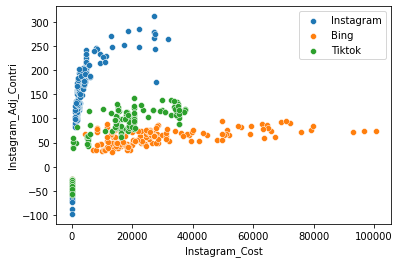

In [ ]:
# Contribution Charts
sns.scatterplot(data=df,x='Instagram_Cost',y='Instagram_Adj_Contri',label='Instagram')
sns.scatterplot(data=df,x='Bing_Cost',y='Bing_Adj_Contri',label='Bing')
sns.scatterplot(data=df,x='Tiktok Cost',y='Tiktok_Adj_Contri',label='Tiktok')


<AxesSubplot:xlabel='Facebook_Cost', ylabel='Facebook_Adj_Contri'>

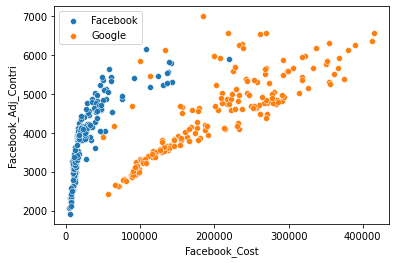

In [ ]:
sns.scatterplot(data=df,x='Facebook_Cost',y='Facebook_Adj_Contri',label='Facebook')
sns.scatterplot(data=df,x='Google_Cost',y='Google_Adj_Contri',label='Google')


<AxesSubplot:xlabel='Facebook_Cost', ylabel='Facebook_Adj_Contri'>

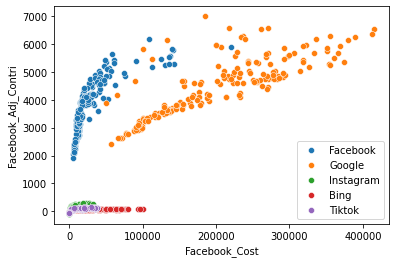

In [ ]:
sns.scatterplot(data=df,x='Facebook_Cost',y='Facebook_Adj_Contri',label='Facebook')
sns.scatterplot(data=df,x='Google_Cost',y='Google_Adj_Contri',label='Google')

sns.scatterplot(data=df,x='Instagram_Cost',y='Instagram_Adj_Contri',label='Instagram')
sns.scatterplot(data=df,x='Bing_Cost',y='Bing_Adj_Contri',label='Bing')
sns.scatterplot(data=df,x='Tiktok Cost',y='Tiktok_Adj_Contri',label='Tiktok')


<AxesSubplot:xlabel='Pinterest_Cost', ylabel='Pinterest_Adj_Contri'>

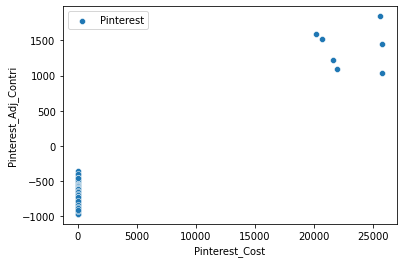

In [ ]:
sns.scatterplot(data=df,x='Pinterest_Cost',y='Pinterest_Adj_Contri',label='Pinterest')